In [34]:
import sys
sys.path.append('..')
import torch
import numpy as np
import matplotlib.pyplot as plt
from HeatEquation_DeepHPM import HeatEquationHPMNet, load_checkpoint, getDefaults, loadTimesteps
from UKDDataset import HeatEquationHPMDataset, SchrodingerEquationDataset

In [47]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
args = Namespace(pData=pathData, maxFrames = 500)
coordinateSystem = getDefaults(args)

500 frames <-> tmax: 9.6 seconds


The following code initializes our models and loads a pretrained model from `pathModel`. 

In [49]:
pathModel = 'results/models/UKD_DeepHPM/0_ic/model_3500.pt'
pathData = '../../data/UKD/2014_022_rest.mat'

lb = np.array([coordinateSystem["x_lb"], coordinateSystem["y_lb"], 0.])
ub = np.array([coordinateSystem["x_ub"], coordinateSystem["y_ub"], coordinateSystem["tmax"]])

nx = 640
ny = 480
nt = maxFrames
maxFrames = 500
numFeatures = 500
numLayers = 8
numLayers_hpm = 8
numFeatures_hpm = 300


model = HeatEquationHPMNet(numLayers, numFeatures, numLayers_hpm, numFeatures_hpm, lb, ub,
                          5, 5, torch.tanh).cuda()

In [50]:
load_checkpoint(model, pathModel)

Let's create a dataset object amd check the output of the neural network on a certain slice (index) of that 

In [57]:
numBatches = 500
batchSize = 307200
ds = HeatEquationHPMDataset(pathData, coordinateSystem, numBatches, batchSize, maxFrames=maxFrames, shuffle=False, useGPU=False)

and evaluate the dataset on every time step of the simulation

In [67]:
Es = np.zeros( (nx*ny,nt) )
i = 0
for x, y, t, Ex_u in ds:
    #t = ti * np.ones(nx*ny)
    #t = torch.from_numpy(t)
    inputX = torch.stack([x, y, t], 1).float().cuda()
    Ex_u_pred = model.forward(inputX.cuda()).view(-1).detach().cpu().numpy()
    Es[:,i] = Ex_u_pred.reshape(-1)
    i = i+1

IndexError: index 100 is out of bounds for axis 1 with size 100

Load ground-truth temperatures from file:

In [10]:
u, timing = ds.loadFrame(pathData)

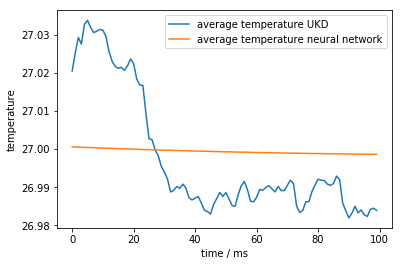

In [96]:
plt.plot(range(nt), np.mean(u[0:nt,:],1), range(nt), np.mean(Es,0))
plt.legend(['average temperature UKD', 'average temperature neural network'])
plt.xlabel('time / ms')
plt.ylabel('temperature')
plt.show()

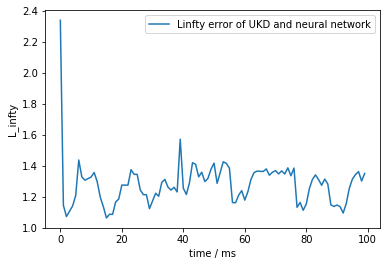

In [95]:
plt.plot(range(nt), np.max((Es - u[0:nt,:].transpose()),axis=0))
plt.legend(['Linfty error of UKD and neural network'])
plt.xlabel('time / ms')
plt.ylabel('L_infty')
plt.show()

Visualize some slice (499) of the training set

In [81]:
x, y, t, Ex_u = ds.__getitem__(499)

inputX = torch.stack([x, y, t], 1)
Ex_u_pred = model.forward(inputX.cuda()).view(-1)
Ex_u_pred = Ex_u_pred.cpu().detach().numpy().reshape(640,480)

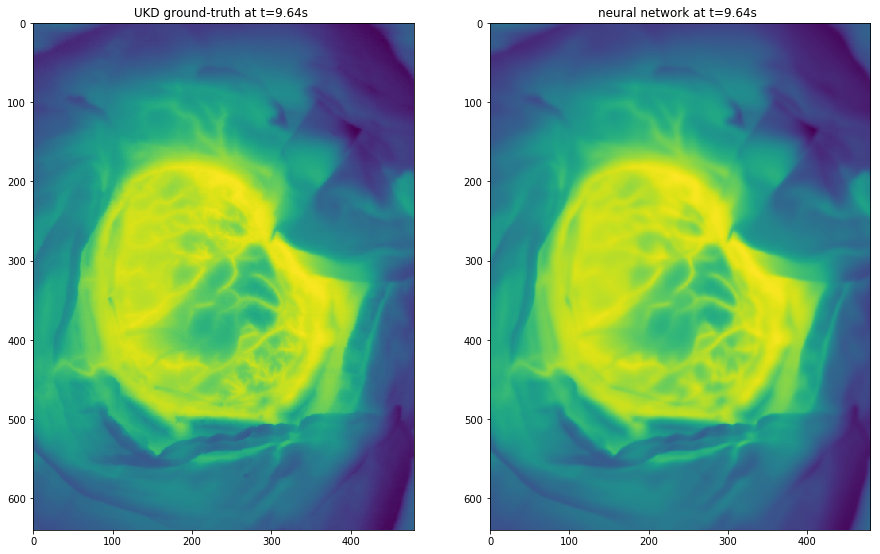

In [82]:
f, axarr = plt.subplots(1, 2, figsize=(15, 10))
cm = ['RdBu_r', 'viridis']

pcm = axarr[0].imshow(Ex_u.reshape(640,480))
axarr[0].set_title('UKD ground-truth at t=%.2fs ' % (t[0]))

pcm = axarr[1].imshow(Ex_u_pred)
axarr[1].set_title('neural network at t=%.2fs ' % (t[0]))

plt.show()